There are 100+ types of flowers which are to be classified. A labeled set is given for training. In this kernel I will make a GoogLeNet for the problem statement. In a previous kernel I used VGG16 network to train on the same dataset. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/train-data/train.csv
/kaggle/input/train-data/train_X.npy


Let's import packages

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
from keras.utils import to_categorical 
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dropout, Dense, Flatten, Activation, concatenate
from keras.initializers import glorot_uniform, he_uniform, Zeros
import matplotlib.pyplot as plt

Using TensorFlow backend.


To save some time and more importantly space. I already saved the images as numpy arrays of size 100 * 100. Let's get the data.

In [3]:
train_X = np.load("/kaggle/input/train-data/train_X.npy")

train_y = np.asarray(pd.read_csv("/kaggle/input/train-data/train.csv").iloc[:,1])

train_y = to_categorical(train_y)

Inception Block

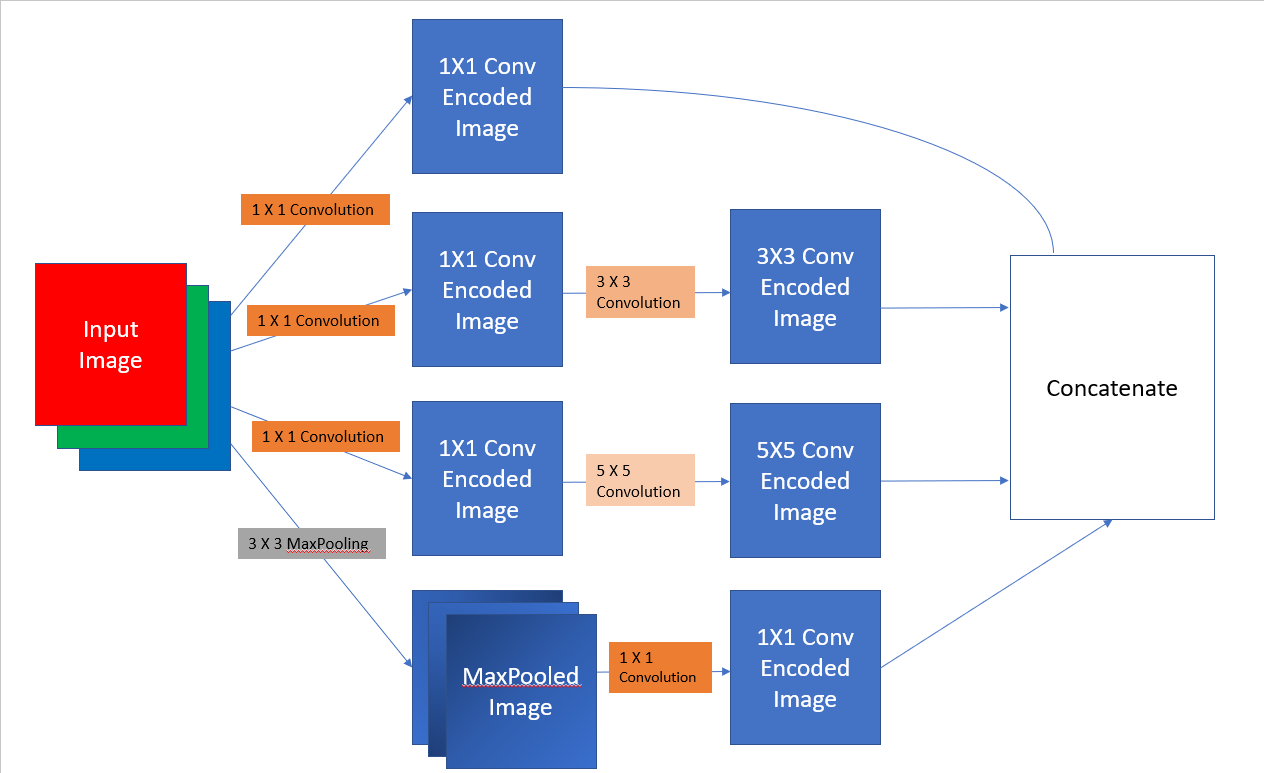

In [4]:
kernel_init = glorot_uniform()
bias_init = Zeros()
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    conv_1x1 = Conv2D(filters_1x1, kernel_size=(1,1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer = bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, kernel_size=(1,1), padding='same', activation ='relu', kernel_initializer=kernel_init, bias_initializer = bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, kernel_size=(3,3), padding='same', activation ='relu', kernel_initializer=kernel_init, bias_initializer = bias_init)(x)
    
    conv_5x5 = Conv2D(filters_5x5_reduce, kernel_size=(1,1), padding='same', activation ='relu', kernel_initializer=kernel_init, bias_initializer = bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, kernel_size=(3,3), padding='same', activation ='relu', kernel_initializer=kernel_init, bias_initializer = bias_init)(x)
    
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init)(pool_proj)
    
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output
    

GoogLeNet / Inception V1 Network

In [5]:
input_layer = Input(shape=(100, 100, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init)(input_layer)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)


x = inception_module(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32, name='inception_3a')

x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64, name='inception_3b')

x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x, filters_1x1=192, filters_3x3_reduce=96,filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64, name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(103, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64, name='inception_4b')

x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64, name='inception_4c')

x = inception_module(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32,filters_5x5=64, filters_pool_proj=64, name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(103, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128, name='inception_4e')

x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128, name='inception_5a')

x = inception_module(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128, name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
x = Dropout(0.4)(x)
x = Dense(103, activation='softmax', name='output')(x)


In [6]:
model = Model(input_layer, [x1, x2, x], name='inception_v1')

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 50, 50, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 25, 25, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 25, 25, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [7]:
model.fit(train_X, [train_y, train_y, train_y], validation_split=0.2, epochs = 100, batch_size=64)

Train on 14832 samples, validate on 3708 samples
Epoch 1/100
14832/14832 [==============================] - 27s 2ms/step - loss: 13.3487 - auxilliary_output_1_loss: 4.3998 - auxilliary_output_2_loss: 4.3824 - output_loss: 4.5654 - auxilliary_output_1_accuracy: 0.0467 - auxilliary_output_2_accuracy: 0.0398 - output_accuracy: 0.0443 - val_loss: 11.6277 - val_auxilliary_output_1_loss: 3.8153 - val_auxilliary_output_2_loss: 3.9215 - val_output_loss: 3.8917 - val_auxilliary_output_1_accuracy: 0.0868 - val_auxilliary_output_2_accuracy: 0.0645 - val_output_accuracy: 0.0747
Epoch 2/100
14832/14832 [==============================] - 19s 1ms/step - loss: 10.9576 - auxilliary_output_1_loss: 3.5645 - auxilliary_output_2_loss: 3.7198 - output_loss: 3.6728 - auxilliary_output_1_accuracy: 0.1180 - auxilliary_output_2_accuracy: 0.0866 - output_accuracy: 0.1009 - val_loss: 9.7405 - val_auxilliary_output_1_loss: 3.1555 - val_auxilliary_output_2_loss: 3.3197 - val_output_loss: 3.2662 - val_auxilliary_out

Text(0.5, 0, 'Epochs')

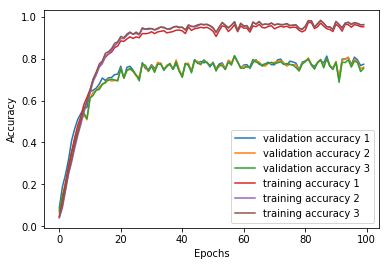

In [8]:
plt.plot(model.history.history['val_auxilliary_output_1_accuracy'])
plt.plot(model.history.history['val_auxilliary_output_2_accuracy'])
plt.plot(model.history.history['val_output_accuracy'])
plt.plot(model.history.history['auxilliary_output_1_accuracy'])
plt.plot(model.history.history['auxilliary_output_2_accuracy'])
plt.plot(model.history.history['output_accuracy'])
plt.legend(['validation accuracy 1','validation accuracy 2', 'validation accuracy 3', 'training accuracy 1','training accuracy 2', 'training accuracy 3'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')